# Fake News Detection Project

## Step 1: Data Loading and Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load the dataset

In [5]:
# Load both datasets
fake_df = pd.read_csv('/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv')

# Add labels: 1 for Fake, 0 for True
fake_df['label'] = 1
true_df['label'] = 0

# Merge the datasets
combined_df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [6]:
# Check for required columns and handle missing ones
required_cols = ['text', 'title', 'subject']

# If 'text' column doesn't exist but 'content' does, rename it
if 'text' not in combined_df.columns and 'content' in combined_df.columns:
    combined_df.rename(columns={'content': 'text'}, inplace=True)

# Ensure we have text content to work with
if 'text' not in combined_df.columns:
    # If no text column, try to use title as text
    if 'title' in combined_df.columns:
        combined_df['text'] = combined_df['title']
    else:
        raise ValueError("Neither 'text' nor 'title' columns found in dataset")

# Drop rows with missing text
combined_df = combined_df.dropna(subset=['text'])

# Shuffle the data
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Step 2: Data Preprocessing

In [7]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Fill nulls and combine title and text
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['content'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['content'].apply(clean_text)

## Step 3: Feature Extraction

In [8]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

## Step 4: Splitting Data

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Step 5: Model Training

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

## Step 6: Model Evaluation

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



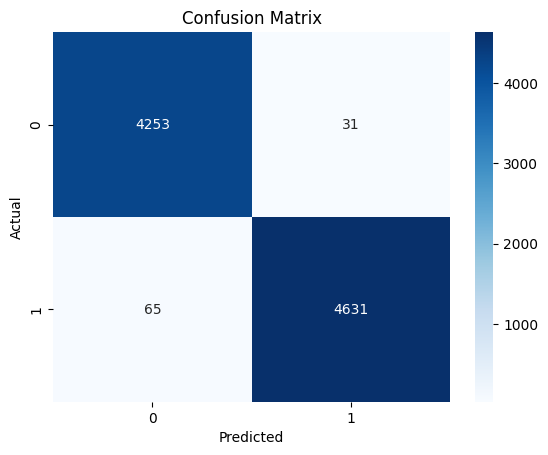

In [11]:

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ROC Curve

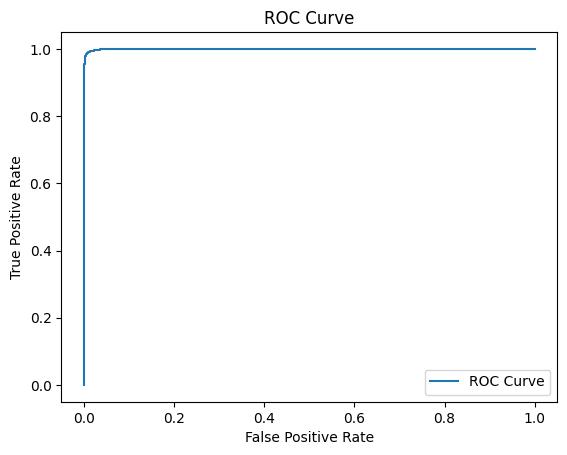

ROC-AUC Score: 0.9994938279116303


In [12]:

probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, probs))